In [3]:
!pip install langgraph langchain langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00


Game State Machine Structure:


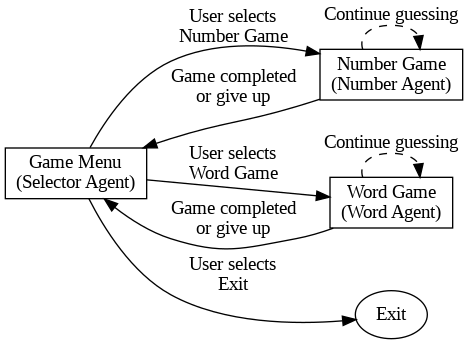


Starting game... Follow the prompts to play.

Main Menu:
1. Number Game
2. Word Game
3. Exit
Choose a game (1/2) or Exit (3): 2
Think of a word from this list:
apple, chair, elephant, guitar, rocket, pencil, pizza, tiger
Enter your secret word (for testing purposes): chair
Is it a living thing? (yes/no): no
Is it an animal? (yes/no): no
Is it an object? (yes/no): yes
Is it used in school? (yes/no): yes
Is it a musical instrument? (yes/no): no
Is it edible? (yes/no): no
Does it have four legs? (yes/no): yes

I think your word is: **chair**
Am I right? (yes/no): yes
Yay! I guessed your word!

Main Menu:
1. Number Game
2. Word Game
3. Exit
Choose a game (1/2) or Exit (3): 3

Game completed. Visualizing execution path...


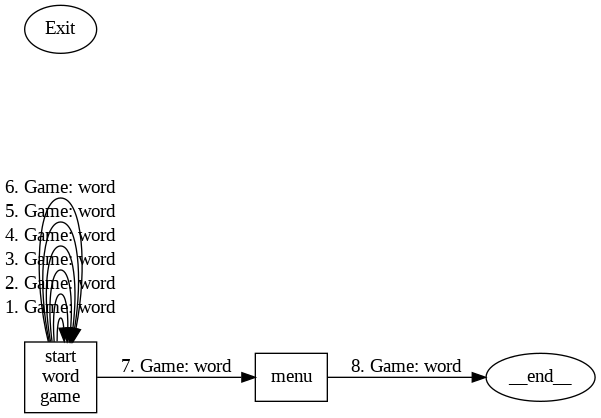

Execution path: ['start_word_game', 'start_word_game', 'start_word_game', 'start_word_game', 'start_word_game', 'start_word_game', 'start_word_game', 'menu', '__end__']

Final Game State:
current_game: word
number_guess_min: 1
number_guess_max: 50
number_game_count: 0
word_game_count: 1
session_games: ['word']
word_attempts: 7
target_word: chair
possible_words: None
_next: __end__


In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Optional
from graphviz import Digraph
from IPython.display import display, Image

# ------------------ GAME STATE ------------------ #
class GameState(TypedDict):
    current_game: Optional[str]
    number_guess_min: int
    number_guess_max: int
    number_game_count: int
    word_game_count: int
    session_games: List[str]
    word_attempts: int
    target_word: Optional[str]
    possible_words: List[str]
    _next: str

# ------------------ GLOBALS ------------------ #
WORD_LIST = ["apple", "chair", "elephant", "guitar", "rocket", "pencil", "pizza", "tiger"]
CLUE_QUESTIONS = {
    "Is it a living thing?": lambda word: word in ["apple", "elephant", "tiger"],
    "Is it an animal?": lambda word: word in ["elephant", "tiger"],
    "Is it an object?": lambda word: word not in ["elephant", "tiger", "apple"],
    "Is it used in school?": lambda word: word in ["chair", "pencil"],
    "Is it a musical instrument?": lambda word: word == "guitar",
    "Is it edible?": lambda word: word in ["apple", "pizza"],
    "Does it have four legs?": lambda word: word in ["elephant", "tiger", "chair"],
    "Can it fly?": lambda word: word == "rocket"
}

# ------------------ EXECUTION TRACKER ------------------ #
class ExecutionTracker:
    def __init__(self):
        self.steps = []
        self.current_state = None

    def track(self, state):
        self.current_state = state.get("_next", END)
        self.steps.append({
            "node": self.current_state,
            "game": state.get("current_game"),
            "action": f"Game: {state.get('current_game')}" if state.get("current_game") else "Menu"
        })
        return state

# ------------------ AGENTS ------------------ #
def game_selector_agent(state: GameState) -> GameState:
    print("\nMain Menu:\n1. Number Game\n2. Word Game\n3. Exit")
    choice = input("Choose a game (1/2) or Exit (3): ").strip()
    if choice == "1":
        state["current_game"] = "number"
        state["_next"] = "start_number_game"
    elif choice == "2":
        state["current_game"] = "word"
        state["_next"] = "start_word_game"
    else:
        state["_next"] = END
    return state

def number_game_agent(state: GameState) -> GameState:
    min_val = state["number_guess_min"]
    max_val = state["number_guess_max"]
    mid = (min_val + max_val) // 2

    response = input(f"Is your number greater than {mid}? (yes/no): ").strip().lower()
    if response == "yes":
        state["number_guess_min"] = mid + 1
    else:
        state["number_guess_max"] = mid

    if state["number_guess_min"] == state["number_guess_max"]:
        print(f"\nYour number is {state['number_guess_min']}! I guessed it!")
        state["number_game_count"] += 1
        state["session_games"].append("number")
        state["number_guess_min"] = 1
        state["number_guess_max"] = 50
        state["_next"] = "menu"
    else:
        state["_next"] = "start_number_game"
    return state

def word_game_agent(state: GameState) -> GameState:
    if "possible_words" not in state or state["possible_words"] is None:
        state["possible_words"] = WORD_LIST.copy()

    if "target_word" not in state or state["target_word"] is None:
        print("Think of a word from this list:")
        print(", ".join(WORD_LIST))
        state["target_word"] = input("Enter your secret word (for testing purposes): ").strip().lower()

    if state["word_attempts"] < len(CLUE_QUESTIONS):
        questions = list(CLUE_QUESTIONS.keys())
        question_idx = state["word_attempts"]
        question = questions[question_idx]
        answer = input(f"{question} (yes/no): ").strip().lower()

        predicate = CLUE_QUESTIONS[question]
        filtered_words = []

        for word in state["possible_words"]:
            try:
                if predicate(word) and answer == "yes":
                    filtered_words.append(word)
                elif not predicate(word) and answer == "no":
                    filtered_words.append(word)
            except Exception as e:
                print(f"Error evaluating clue for '{word}': {e}")
                continue

        state["possible_words"] = filtered_words
        state["word_attempts"] += 1

        if len(filtered_words) == 1:
            guess = filtered_words[0]
            print(f"\nI think your word is: **{guess}**")
            correct = input("Am I right? (yes/no): ").strip().lower()
            if correct == "yes":
                print("Yay! I guessed your word!")
                state["word_game_count"] += 1
                state["session_games"].append("word")
                state["possible_words"] = None
                state["_next"] = "menu"
            else:
                print("Hmm, let me try again.")
                state["possible_words"] = WORD_LIST.copy()
                state["word_attempts"] = 0
                state["_next"] = "start_word_game"
        elif len(filtered_words) == 0:
            print("No matching words found. Let's start over.")
            state["possible_words"] = WORD_LIST.copy()
            state["word_attempts"] = 0
            state["_next"] = "start_word_game"
        else:
            state["_next"] = "start_word_game"
    else:
        if len(state["possible_words"]) > 1:
            guess = state["possible_words"][0]
            print(f"\nMy best guess is: **{guess}**")
        else:
            guess = state["possible_words"][0]
            print(f"\nMy guess is: **{guess}**")

        correct = input("Am I right? (yes/no): ").strip().lower()
        state["word_game_count"] += 1
        state["session_games"].append("word")

        if correct == "yes":
            print("Yay! I guessed your word!")
        else:
            print(f"Oops! The correct word was: **{state['target_word']}**")

        state["possible_words"] = None
        state["_next"] = "menu"

    return state

# ------------------ ROUTER ------------------ #
def router(state: GameState) -> str:
    return state.get("_next", END)

# ------------------ VISUALIZATION ------------------ #
def visualize_structure():
    dot = Digraph(comment='Game State Machine', format='png')
    dot.attr(rankdir='LR', size='8,5')

    dot.node('menu', 'Game Menu\n(Selector Agent)', shape='rectangle')
    dot.node('start_number_game', 'Number Game\n(Number Agent)', shape='rectangle')
    dot.node('start_word_game', 'Word Game\n(Word Agent)', shape='rectangle')
    dot.node('END', 'Exit', shape='ellipse')

    dot.edge('menu', 'start_number_game', label='User selects\nNumber Game')
    dot.edge('menu', 'start_word_game', label='User selects\nWord Game')
    dot.edge('menu', 'END', label='User selects\nExit')

    dot.edge('start_number_game', 'menu', label='Game completed\nor give up')
    dot.edge('start_word_game', 'menu', label='Game completed\nor give up')

    dot.edge('start_number_game', 'start_number_game', label='Continue guessing', style='dashed')
    dot.edge('start_word_game', 'start_word_game', label='Continue guessing', style='dashed')

    display(Image(dot.pipe(format='png')))
    return dot

def visualize_execution(execution_steps):
    dot = Digraph(comment='Execution Trace', format='png')
    dot.attr(rankdir='LR', size='8,5')

    nodes = set(step["node"] for step in execution_steps if step["node"] != END)
    for node in nodes:
        dot.node(node, node.replace('_', '\n'), shape='rectangle')

    if any(step["node"] == END for step in execution_steps):
        dot.node('END', 'Exit', shape='ellipse')

    for i, step in enumerate(execution_steps[:-1]):
        next_step = execution_steps[i+1]
        label = f"{i+1}. {step.get('action', '')}"
        dot.edge(step["node"], next_step["node"], label=label)

    if execution_steps[-1]["node"] != END:
        dot.node(execution_steps[-1]["node"], color='red', style='filled', fillcolor='#ffcccc')

    display(Image(dot.pipe(format='png')))
    return dot

def print_game_state(state: GameState):
    print("\nFinal Game State:")
    for key, value in state.items():
        print(f"{key}: {value}")

# ------------------ MAIN EXECUTION ------------------ #
def main():
    # Initialize tracker
    tracker = ExecutionTracker()

    # Initial state
    initial_state: GameState = {
        "current_game": None,
        "number_guess_min": 1,
        "number_guess_max": 50,
        "number_game_count": 0,
        "word_game_count": 0,
        "session_games": [],
        "word_attempts": 0,
        "target_word": None,
        "possible_words": None,
        "_next": "menu"
    }

    # Build the graph with tracking
    builder = StateGraph(GameState)

    # Add nodes with tracking
    builder.add_node("menu", lambda state: tracker.track(game_selector_agent(state)))
    builder.add_node("start_number_game", lambda state: tracker.track(number_game_agent(state)))
    builder.add_node("start_word_game", lambda state: tracker.track(word_game_agent(state)))

    builder.set_entry_point("menu")

    builder.add_conditional_edges("menu", router)
    builder.add_conditional_edges("start_number_game", router)
    builder.add_conditional_edges("start_word_game", router)

    app = builder.compile()

    # Show structure before execution
    print("Game State Machine Structure:")
    visualize_structure()

    # Run the app
    print("\nStarting game... Follow the prompts to play.")
    #app.invoke(initial_state)
    final_state = app.invoke(initial_state)
    # Visualize execution
    print("\nGame completed. Visualizing execution path...")
    visualize_execution(tracker.steps)

    print(f"Execution path: {[step['node'] for step in tracker.steps]}")
        # Print final state
    print_game_state(final_state)

if __name__ == "__main__":
    main()